In [1]:
import pandas as pd
from datetime import datetime
import ta 
import numpy as np  
import matplotlib.pyplot as plt
import warnings
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
warnings.filterwarnings("ignore")
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()
# %matplotlib notebook
###https://github.com/kunalkini15/technical_indicators_lib/blob/master/technical_indicators_lib/indicators.py

#############################
def load_dataset(filename):
    try:
        df = pd.read_csv(filename)
        df = df.reset_index(drop=True)
        df['date'] = pd.to_datetime(df.date) # Convert date column values to datetime
        df.set_index('date', inplace=True)  # set date column as index
        df = df.replace(',','', regex=True).astype(float) # Replace commas and make the dtype float
#         df = df.sort_index(ascending=True) # Sort index
        return df
    except Exception as e:
        print("Exception in loading dataset: ",e)
        
#################################
def cal_rsi_df(prices):
#     prices = prices.values()[:14]
    i = 0
    upPrices=[]
    downPrices=[]
    #  Loop to hold up and down price movements
    while i < len(prices):
        if i == 0:
            upPrices.append(0)
            downPrices.append(0)

        # If previous day price is less than price is up
        elif (prices[i] - prices[i-1]) > 0: 
            upPrices.append(prices[i]-prices[i-1])
            downPrices.append(0)

        # If previous day price is greater than price is down
        else:
            downPrices.append(prices[i]-prices[i-1])
            upPrices.append(0)

        i += 1
    ##############
    #  Loop to calculate the average gain and loss over days
    x = 0
    avg_gain = []
    avg_loss = []
    while x < len(upPrices):

        if x < 15:
            avg_gain.append(0)
            avg_loss.append(0)
        
        # As it uses 14 days period so for first 14 days append 0.
        else:
            sumGain = 0
            sumLoss = 0
            y = x-14 # 
        
            while y <= x:
                sumGain += upPrices[y] #Update Gains with prices that went up compared to previous day
                sumLoss += downPrices[y] # Update Loss with prices that went down compared to previous day
                y += 1 # Increment Y
            avg_gain.append(sumGain/14) # Get average gain of 14 days
            avg_loss.append(abs(sumLoss/14)) # Get average loss of 14 days
        
        x += 1
    #########################
    p = 0
    RS = []
    RSI = []
    
    #  Loop to calculate RSI and RS
    while p < len(prices):
        
        if p <15:
            RS.append(0)
            RSI.append(0)
        
        else:
            RSvalue = (avg_gain[p]/avg_loss[p])
            RS.append(RSvalue)
            RSI.append(100 - (100/(1+RSvalue)))
        p+=1
        
        
    #  Creates the data frame for each stock's RSI and price movements
    
    df_dict = {
        'Prices' : prices,
        'upPrices' : upPrices,
        'downPrices' : downPrices,
        'AvgGain' : avg_gain,
        'AvgLoss' : avg_loss,
        'RS' : RS,
        'RSI' : RSI
    }

    df = pd.DataFrame(df_dict, columns = ['Prices', 'upPrices', 'downPrices', 'AvgGain','AvgLoss', 'RS', "RSI"])
    
    return df # return a data frame containing all the information about data of given stock
####################################################################################
def ema(df, n):
    """
    returns an n period exponential moving average for
    the time series s

    s is a list ordered from oldest (index 0) to most
    recent (index -1)
    n is an integer

    returns a numeric array of the exponential
    moving average
    """
    s = np.array(df)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(s[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (s[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in s[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)
    ema = pd.DataFrame(ema,columns=['ema'],index=df.index[:len(ema)]) 
    return ema
####################################################################################
def calculate_ta(df):
    ## Datetime conversion
#     df['date'] = pd.to_datetime(df.date)
#     # Setting the index
#     df.set_index('date', inplace=True)
    # Adding all the indicators
    df = ta.add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)
    # Dropping everything else besides 'Close' and the Indicators
#     df = df.drop(['open', 'high', 'low', 'change', 'volume'], axis=1, inplace=True) # Drop Unnecessary
    return df #Return a dataframe that contains all the technical indicators
#####################################
def technical_indicator(df,ta_name):
    df = calculate_ta(df)
    return df[ta_name]
#################################################
def get_technical_indicators_list(df):

    return calculate_ta(df).columns
##################################################
def plot(values):
    plt.figure(figsize=(15,7))
    plt.plot(values, color='green',label='Data')  # Actual Data
    plt.title('History Of Close Price') # Title 
    plt.legend(loc='best') #An area specifying the element
###################################################
def sma(data, window): # Simple moving average using given window 
    sma = data.rolling(window = window).mean()
    return sma
###################################################
def bb(data, sma, window):# Calculate bollinger bands
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

In [2]:
df = load_dataset('./companies/KSE-100.csv')
df

,open,high,low,close,change,volume
date,,,,,,
2021-06-23,48016.64,48134.94,47873.14,47900.70,-86.44,237206903.0
2021-06-22,48030.28,48154.56,47931.78,47987.14,-25.38,209250013.0
2021-06-21,48252.41,48370.42,47963.97,48012.52,-226.15,227403647.0
2021-06-18,48156.71,48411.87,48022.72,48238.67,81.04,304366997.0
2021-06-17,48478.62,48544.65,48115.84,48157.63,-323.27,290742124.0
...,...,...,...,...,...,...
2001-01-05,1551.70,1565.67,1543.96,1545.90,-4.14,196956064.0
2001-01-04,1552.91,1561.64,1546.08,1550.04,-0.38,213918640.0
2001-01-03,1517.94,1550.42,1517.94,1550.42,28.26,221411648.0


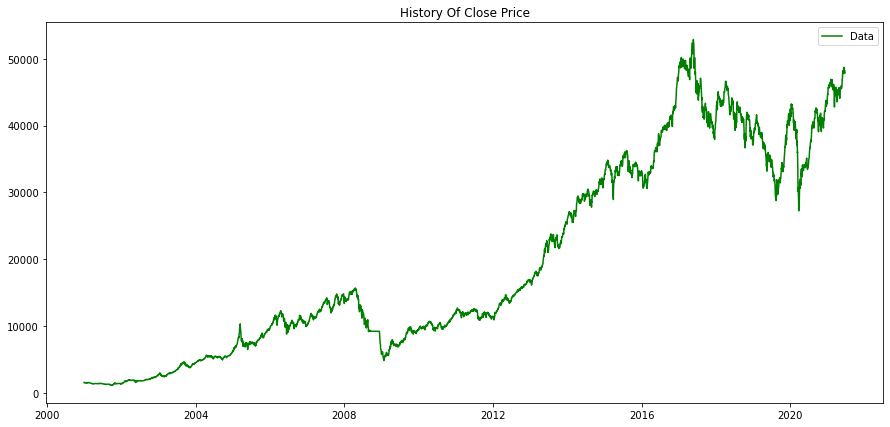

In [3]:
plot(df['close'])

## Technical Indicators

In [4]:
calculate_ta(df).columns

Index(['open', 'high', 'low', 'close', 'change', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       '

## Relative Strength Index

### RSI provides signals about bullish and bearish price momentum

### Formula  = 100 - [ 100 / 1 + Avg_gain / Avg_loss ]

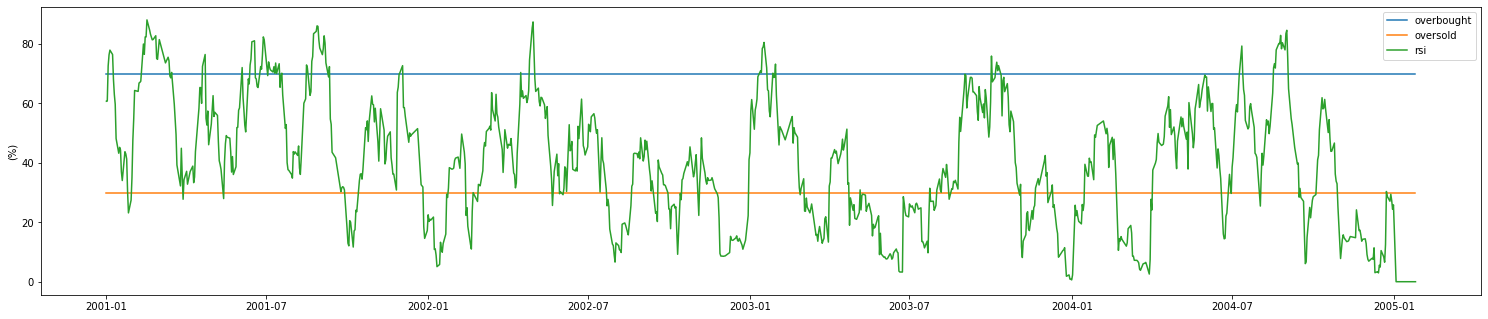

In [5]:
close = df['close'][-1000:]
rsi = cal_rsi_df(close)['RSI']
# Plot RSI
# Above 70% = overbought, below 30% = oversold
fig = plt.figure()
fig.set_size_inches((20, 20))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))
ax_rsi.set_ylabel("(%)")
ax_rsi.plot(rsi.index, [70] * len(rsi.index), label="overbought")
ax_rsi.plot(rsi.index, [30] * len(rsi.index), label="oversold")
ax_rsi.plot(rsi.index, rsi, label="rsi")
ax_rsi.legend()

## MACD

##### EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
##### where Multiplier = ( 2 /  number_of_obs +  1 )
##### MACD = 26-Period EMA − 12-Period EMA  
##### MACD_SIGNAL = 9-Period EMA

##### If MACD falls below the signal line, it is a bearish signal
##### If MACD rises above the signal line, it is a bullish signal

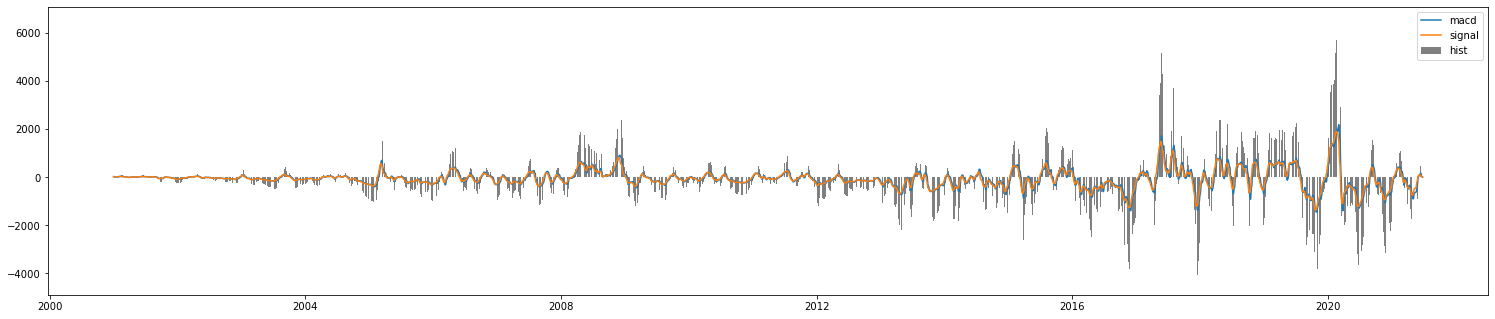

In [6]:
macd = technical_indicator(df,'trend_macd')
macd_signal = technical_indicator(df,'trend_macd_signal')
# Plot MACD
fig = plt.figure()
fig.set_size_inches((20, 20))
ax_macd = fig.add_axes((0, 0.48, 1, 0.2))
ax_macd.plot(macd.index, macd, label="macd")
ax_macd.bar(macd.index,macd * 3 , label="hist",color = 'gray')
ax_macd.plot(macd.index, macd_signal, label="signal")

ax_macd.legend()

# Exponential Moving Average

In [7]:
ema200 = ema(df['close'],200) #EMA (200)
ema100 = ema(df['close'],100) #EMA (100)
ema50 = ema(df['close'],50) #EMA (50)
ema20 = ema(df['close'],20) # EMA (20)
ema9 = ema(df['close'],9) # EMA (9)

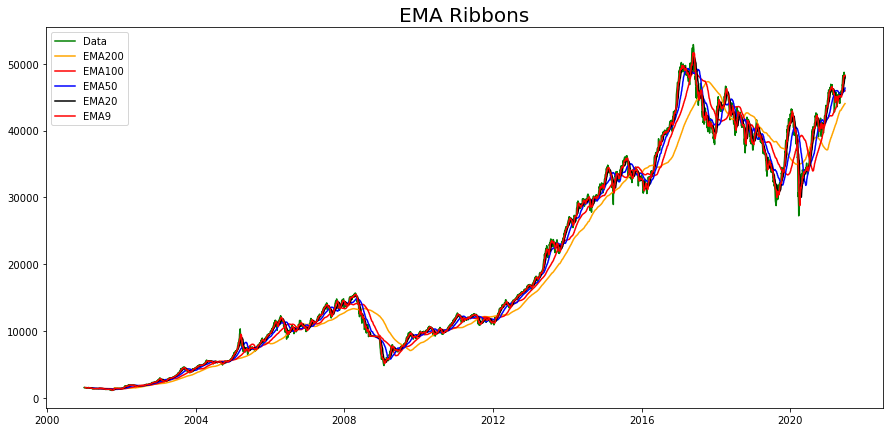

In [8]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], color='green',label='Data')
plt.plot(ema200, color='orange',label='EMA200')
plt.plot(ema100, color='red',label='EMA100')
plt.plot(ema50, color='blue',label='EMA50')
plt.plot(ema20, color='black',label='EMA20')
plt.plot(ema9, color='red',label='EMA9')
plt.title('EMA Ribbons', size = 20) # Title 
plt.legend(loc='best') #An area ng the element

# Bollinger Bands
## Gives buy, sell and volaltility strength.
## Uses Simple Moving Average (SMA) of a stock close price to calculate upper 
## and lower line of bollinger band
## std = rolling standard deviation of stock price
## Upper BB = sma + std * 2
## Lower BB = sma - std * 2

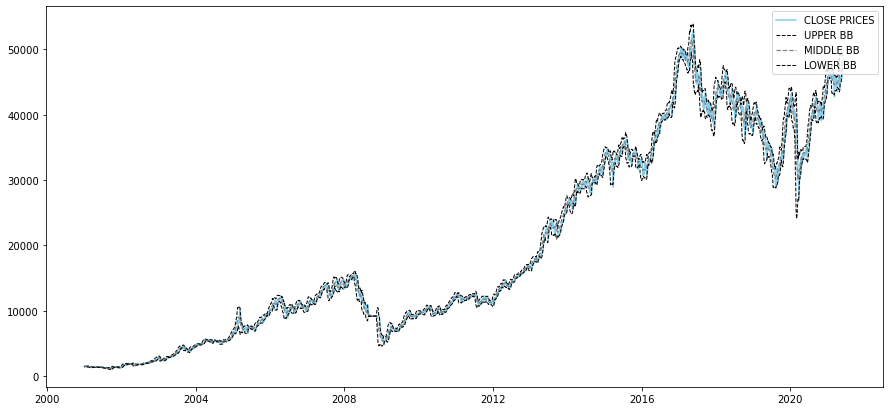

In [9]:
temp = pd.DataFrame()
temp['close'] = df['close']
temp['sma'] = sma(df['close'], 20)
temp['upper_bb'], temp['lower_bb'] = bb(temp['close'], temp['sma'], 20)

fig = plt.figure()
fig.set_size_inches((15, 7))
plt.plot(temp['close'],label = 'CLOSE PRICES', color = 'skyblue')
plt.plot(temp['upper_bb'],label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.plot(temp['sma'],label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
plt.plot(temp['lower_bb'],label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper right')
